In [8]:
import os
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [9]:
# setup pytorch gpu
print(torch.cuda.is_available())
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
12.1


In [10]:
#load saved files
fname = 'processed/0_categories'

def file_loader(fname, reformat):
    """
    Loads saved data (in this specific project)
    """
    with open(f'./data/{fname}_x.pkl', 'rb') as f:
        firing_rates = pickle.load(f)
    with open(f'./data/{fname}_y.pkl', 'rb') as f:
        y_np = pickle.load(f)
    print(f'loaded data: X ({firing_rates.shape}), y ({y_np.shape})')
    
    num_cats = len(np.unique(y_np))

    if reformat:
        #format X as tensor of reordered dims to run CNNs
        firing_rates = torch.from_numpy(firing_rates).permute(2, 0, 1) 
        firing_rates = firing_rates.to(torch.float32)
        #format y as one hot encoding
        y = F.one_hot(torch.from_numpy(y_np).to(torch.int64))
        y = y.to(torch.float32)
    else:
        y = y_np

    return firing_rates, y, num_cats

firing_rates, y, num_cats = file_loader(fname, reformat=True)

loaded data: X ((15595, 93, 252)), y ((15595,))


In [11]:
#train test split
train_split = .8
all_ids = np.arange(firing_rates.shape[1])
np.random.shuffle(all_ids)
train_ids = all_ids[0:int(len(all_ids) * train_split)]
test_ids = all_ids[int(len(all_ids) * train_split):-1]

In [12]:
n_neurons = firing_rates.shape[-1] #number of units: size of input layer
n_bins = firing_rates.shape[0] #always 252 when defined as before
output_cats = num_cats #only two categories?

#param for dataloader
batch_size = 32

n_comps = 5 #n of latent comps to try
learning_rate = 1e-3 #big LR to converge quickly (hopefully)
lambda_l2 = 5e-3 #big l2 regularization
num_epochs = 20 #100 definitely enough, but after ~50 slows down considerably if lr=1e-4. 
#with lr=1e-3 10 might be enough
earlystop_criterion = 20 #how many iters of loss worsening before stopping

In [13]:
class NeuralData(Dataset):
    def __init__(self, train = True):
        if train:
            self.firing_rate = firing_rates[:, train_ids, :]
            self.labels = y[train_ids]
        else:
            self.firing_rate = firing_rates[:, test_ids, :]
            self.labels = y[test_ids]
    
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        rate = self.firing_rate[:, idx]
        # rate = torch.sum(self.firing_rate, axis = 0)[idx]
        label = self.labels[idx]
        return rate, label
    
train_data = NeuralData(train = True)
test_data = NeuralData(train = False)

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [ ]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 10, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

In [ ]:
comps_to_try = [5]
accs = []
losses = []

for n_comps in comps_to_try:
    train_data = NeuralData(train = True)
    test_data = NeuralData(train = False)

    train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)
    #create model
    model = Net(n_comps = n_comps, n_neurons = n_neurons, output_cats = output_cats)

    #loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    loss_list = []
    loss_increase = 0
    prev_loss = 5

    #train
    for epoch in tqdm.tqdm(range(num_epochs)):
        #iterate through train data
        for rate, label in train_loader:
            rate = rate.unsqueeze(1)
            #forward pass 
            pred = model(rate)
            
            l2 = 0
            for p in model.parameters():
                l2 += torch.sum(p ** 2)
            loss = criterion(pred, label) + lambda_l2 * l2
            loss_list.append(loss.item())
            
            #early stopping
            if loss > prev_loss:
                loss_increase += 1
                prev_loss = loss
                if loss_increase > earlystop_criterion:
                    print(f'Early stop at epoch {epoch}, loss = {loss}, didn\'t improve for {earlystop_criterion} iterations')            
            else:
                loss_increase = 0
                prev_loss = loss
                
            #backprop
            optimizer.zero_grad() #zero out grads
            loss.backward() #calculate grad
            optimizer.step() #take step

        print(f'epoch: {epoch}, loss: {loss}')
            
    # testing
    model.eval()
    model.to(device)
    real_labels, predicted_labels = [], []
    with torch.no_grad():
        correct = 0
        total = 0
        for rate, labels in test_loader:
            #load labels
            rate, labels = rate.to(device), labels.to(device)
            rate = rate.unsqueeze(1)
            val, labels = torch.max(labels.data, 1)
            real_labels += list(labels.cpu().numpy())
            #get preds
            preds = model(rate)
            val, predicted = torch.max(preds.data, 1)
            predicted_labels += list(predicted.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accs.append((correct / total)*100)
        losses.append(loss_list)
        print(f"test acc from rates using {n_comps} hidden dims: {(correct / total)*100:.3f}%")

  5%|▌         | 1/20 [00:13<04:14, 13.41s/it]

epoch: 0, loss: 0.2108784019947052


 10%|█         | 2/20 [00:26<04:01, 13.40s/it]

epoch: 1, loss: 0.18843723833560944


 15%|█▌        | 3/20 [00:40<03:49, 13.48s/it]

epoch: 2, loss: 0.11525359749794006


 20%|██        | 4/20 [00:54<03:42, 13.91s/it]

epoch: 3, loss: 0.12615275382995605


 25%|██▌       | 5/20 [01:09<03:31, 14.07s/it]

epoch: 4, loss: 0.11128953844308853


 30%|███       | 6/20 [01:23<03:17, 14.13s/it]

epoch: 5, loss: 0.11076405644416809


 35%|███▌      | 7/20 [01:37<03:03, 14.08s/it]

epoch: 6, loss: 0.14623579382896423


 40%|████      | 8/20 [01:51<02:47, 13.94s/it]

epoch: 7, loss: 0.10822249203920364


 45%|████▌     | 9/20 [02:04<02:32, 13.90s/it]

epoch: 8, loss: 0.1211710274219513


 50%|█████     | 10/20 [02:18<02:17, 13.72s/it]

epoch: 9, loss: 0.11090468615293503


 55%|█████▌    | 11/20 [02:31<02:02, 13.60s/it]

epoch: 10, loss: 0.12757974863052368


 60%|██████    | 12/20 [02:45<01:48, 13.55s/it]

epoch: 11, loss: 0.10411957651376724


 65%|██████▌   | 13/20 [02:58<01:34, 13.52s/it]

epoch: 12, loss: 0.1131853237748146


 70%|███████   | 14/20 [03:11<01:20, 13.47s/it]

epoch: 13, loss: 0.20923417806625366


 75%|███████▌  | 15/20 [03:25<01:07, 13.45s/it]

epoch: 14, loss: 0.13743248581886292


 80%|████████  | 16/20 [03:39<00:54, 13.61s/it]

epoch: 15, loss: 0.11711939424276352


 85%|████████▌ | 17/20 [03:53<00:41, 13.82s/it]

epoch: 16, loss: 0.23062944412231445


 90%|█████████ | 18/20 [04:08<00:28, 14.19s/it]

epoch: 17, loss: 0.10625626891851425


 95%|█████████▌| 19/20 [04:22<00:14, 14.04s/it]

epoch: 18, loss: 0.10590597987174988


100%|██████████| 20/20 [04:35<00:00, 13.79s/it]

epoch: 19, loss: 0.10239189863204956


test acc from rates using 5 hidden dims: 99.262%


Text(0, 0.5, 'loss, cross entropy + L2')

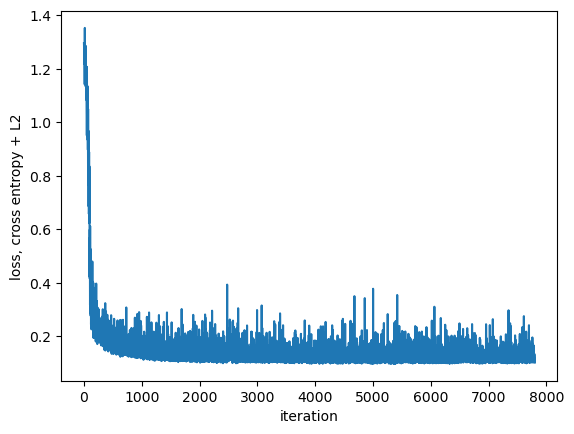

In [11]:
plt.plot(loss_list) 
plt.xlabel('iteration')
plt.ylabel('loss, cross entropy + L2')

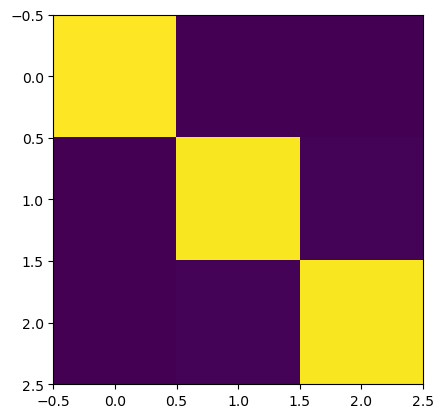

In [12]:
from sklearn.metrics import confusion_matrix

plt.imshow(confusion_matrix(real_labels, predicted_labels, normalize = 'true'))

In [13]:
confusion_matrix(real_labels, predicted_labels)

array([[ 717,    0,    0],
       [   0, 1205,   11],
       [   0,   12, 1173]])

In [ ]:
# #save model for the future in case
# with open('models/cnn_model_3cat99acc.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [15]:
for i, layer in enumerate(model.parameters()):
    print(f'layer {i} num of params: {torch.numel(layer)}')

layer 0 num of params: 576
layer 1 num of params: 64
layer 2 num of params: 18432
layer 3 num of params: 32
layer 4 num of params: 12000
layer 5 num of params: 5
layer 6 num of params: 15
layer 7 num of params: 3
